In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('/home/mz1482/project/vt-bayesian-opt-bopt_debug/my_bayes_opt/')
import bo_new
import math
from numpy.linalg import multi_dot
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from data_analysis import get_heart_bounds, correlation_coef, graph_3d
from graph import narrow,corrplot3axes,trend,nearest,plot_exploration, graph_dist_over_axis, graph_cc_distribution, cube
# from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
# from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
from prettytable import PrettyTable
from scipy.stats import wasserstein_distance

In [2]:
def get_index(label):
    """
    Gets the idx of a label in the labels array
    :param label: label to check for
    :return: idx
    """
    idx = 0
    for coord in labels:
        if np.array_equal(label, coord):
            break
        idx += 1
    return idx

def black_box(x, y, z):
    """
    Represents a black box function to maximize for CC of two ECGs given an XYZ coordinate
    :param x:
    :param y: coordinates of the prediction
    :param z:
    :return: CC of that point and the target
    """
    sample_ecg = ecgs[get_index(np.array([x, y, z]))]
    return abs(correlation_coef(target_ecg, sample_ecg))

def optimize_point(labels,bounds):
    # Build the optimizer with the heart bounds
    optimizer = bo_new.mybo(
        f=black_box,
        pbounds=bounds, real_set=labels
    )

    # Maximize over x number of points
    optimizer.maximize(init_points=10, n_iter=15,  acq="ei", kappa = 2)
    return optimizer


In [3]:
ecgs = pd.read_csv("/home/mz1482/project/vt-bayesian-opt-bopt_debug/simu-data/Heart3_SimuData.csv", header=None).to_numpy()
labels = pd.read_csv("/home/mz1482/project/vt-bayesian-opt-bopt_debug/simu-data/Heart3_XYZsub.csv", header=None).to_numpy() / 1000
# Get bounds of the heart mesh
bounds = get_heart_bounds(labels)
# Pick out a sample to use as a target
tidx = np.random.randint(0, labels.shape[0])
target, target_ecg = labels[tidx], ecgs[tidx]

In [4]:
optimizer = bo_new.mybo(f=black_box,pbounds=bounds, real_set=labels)
gp,X = optimizer.maximize(init_points=5, n_iter=10,  acq="ucb", kappa = 2)

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |         x |         y |         z | 
    1 | 00m00s |    0.22939 |   49.1568 |  -86.3271 |  -47.5074 | 
    2 | 00m00s |    0.14815 |   75.5382 |  -96.4048 |  -89.0396 | 
    3 | 00m00s |    0.16731 |   23.4953 |  -41.4959 |  -57.0576 | 
    4 | 00m00s |    0.50369 |   -7.5753 |  -36.1783 |  -56.3065 | 
    5 | 00m00s |    0.61581 |   -7.0111 | -103.7587 |  -18.1281 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         x |         y |         z | 
    6 | 00m02s |    0.75247 |  -10.0748 | -111.6364 |  -55.9759 | 
    7 | 00m01s |    0.18003 |   72.7738 |  -51.8871 |  -35.0374 | Warning: Test point chose at random due to repeated sample.

    8 | 00m01s |    0.36134 |    2.6568 |  -56.3815 |   -9.0546 | 
    9 | 00m01s |    0.34930 |    6.5186 |  -33.9461 |  -63.0272 | Warning: Test point chose at random

In [5]:
from matplotlib import cm
def gp_plot(gp):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-118, 94, 0.25)
    Y = np.arange(-118, 94, 0.25)
    Z = np.arange(-118, 94, 0.25)
    R = np.array([X,Y,Z]).T
    G = gp.predict(R,return_std=False).reshape(len(X),1)
    surf = ax.plot_surface(X, Y, G, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#     plt.plot(X,G)
#     plt.scatter(Y,G)
#     plt.scatter(Z,G)
    plt.show()

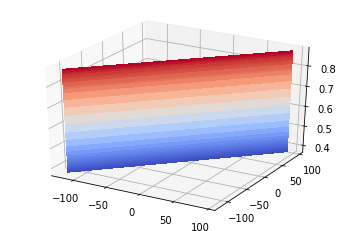

In [6]:
gp_plot(gp)

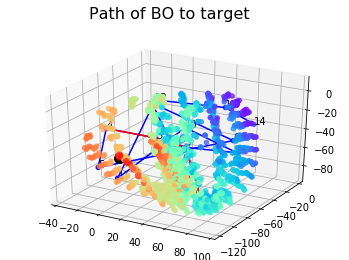

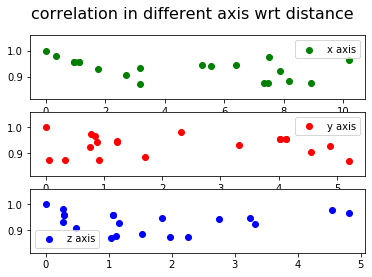

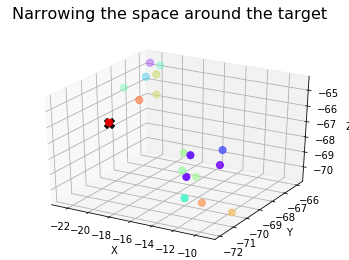

In [7]:
color_gradient = []
# Loop through all points to get CC with that point
for ecg, coord in zip(ecgs, labels):
    if np.array_equal(target_ecg, ecg):
        true = coord
        color_gradient.append(1)
        continue

    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)

plot_exploration(target,labels,optimizer.X, color_gradient)

#     graph_cc_distribution(target_ecg,ecgs,labels)
x,y,z,nn_cc = corrplot3axes(tidx,labels,ecgs,15)
narrow(target,target_ecg,ecgs,labels,15)

In [8]:
y_init = []
keys = list(bounds.keys())
idx= np.random.choice(len(labels), size=5, replace=False)
init_points = labels[idx,:]
for x in init_points:
    y_init.append(black_box(**dict(zip(keys, x))))
x

array([ 53.64726563, -11.19480176, -27.42132422])

In [9]:
optimizer.X[5:len(optimizer.X),:]

array([[ -10.07483008, -111.63642187,  -55.97594531],
       [  72.77382812,  -51.88713672,  -35.03739062],
       [   2.65679565,  -56.38146094,   -9.05457031],
       [   6.51859961,  -33.94607812,  -63.02717188],
       [  81.33114063,  -60.34039453,  -42.3503125 ],
       [  44.60935547,  -75.2508125 ,  -18.01901758],
       [   8.9330166 , -113.66285156,  -62.13070703],
       [   5.49389014,  -56.22520313,   -5.23934814],
       [  50.19548437,  -27.02522656,  -15.46682715],
       [  66.90813281,  -11.28266406,  -35.94316016]])

In [10]:
# data = bo.gp_shape(init_points=5, n_iter=10, acq=af_gp,kappa=3.29,mh_size = 1000)
# z1= data[:,0]
# z2 = data[:,1]
# fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="pdf")

In [11]:
gp

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, hyp_opt_max_iter=1,
                         kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=25, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [12]:
test = np.array([])

In [13]:
def check(test, array):
    """
    Simple generator to check whether a 1d array lies within a multidimensional array
    :param test: value to test for
    :param array: multidimensional array to check through
    :return: true iff test in array
    """
    any(np.array_equal(x, test) for x in array)
    cc = np.corrcoef(test,x)
    return cc


In [14]:
X[1]

array([ 75.53823438, -96.40482031, -89.03957813])

In [15]:
check(X[1],labels)

array([[1.        , 0.97407999],
       [0.97407999, 1.        ]])

In [16]:
np.corrcoef(X[1],target)

array([[1.        , 0.99833699],
       [0.99833699, 1.        ]])

In [17]:
target

array([-19.42402539, -71.1575625 , -65.73139844])

In [18]:
def ecg_return(x,labels,ecgs,target_ecg):
    for i in range(len(labels)):
        if np.array_equal(x, labels[i]):
            e = ecgs[i]
            break
    return np.corrcoef(e,target_ecg)

In [19]:
ecg_return(X[7],labels,ecgs,target_ecg)

array([[1.        , 0.36134248],
       [0.36134248, 1.        ]])

In [20]:
e.shape

NameError: name 'e' is not defined